In [1]:
from data.custom import CustomTrain, CustomTest
from models.vqgan import VQMultiModel
from data.utils import custom_collate
import torch

model = VQMultiModel.load_from_checkpoint("./tinyimagenet/last-v3.ckpt")
model.to("mps")
model.eval()

dataset = CustomTrain(
            training_images_list_file="./tinyimagenet/train.txt",
            size=64
        )

img = custom_collate([dataset[1]])

print(img['image'].shape)


/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Working with z of shape (1, 1024, 16, 16) = 262144 dimensions.


/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
torch.Size([1, 64, 64, 3])


In [2]:
x = model.get_input(custom_collate([dataset[0], dataset[1], dataset[2], dataset[3], dataset[4]]), model.image_key)

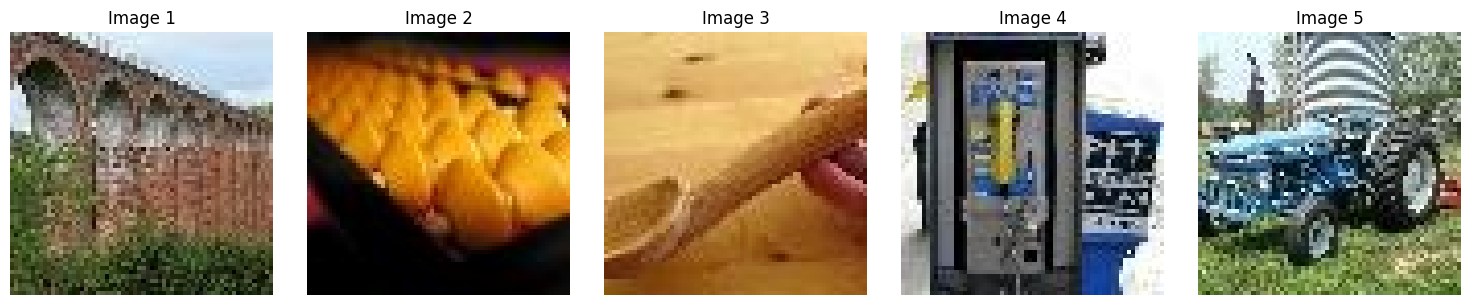

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Convert tensor to image format and move to CPU 
    img = x[i].permute(1,2,0).cpu().numpy()
    # Clip values to valid range
    img = (img * 0.5 + 0.5).clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
tensor([[0.2267, 0.2082],
        [0.1669, 0.2004]])
tensor([[0.0285, 0.0495, 0.0194, 0.0123],
        [0.0257, 0.0670, 0.0364, 0.0390],
        [0.0351, 0.0408, 0.0393, 0.0298],
        [0.0287, 0.0130, 0.0176, 0.0408]])
tensor([[-0.0013,  0.0068,  0.0152,  0.0083,  0.0077,  0.0167,  0.0032,  0.0004],
        [ 0.0061,  0.0103,  0.0330,  0.0203,  0.0117,  0.0063,  0.0021,  0.0013],
        [ 0.0040,  0.0031,  0.0289,  0.0296, -0.0008,  0.0090,  0.0077,  0.0039],
        [ 0.0073,  0.0058,  0.0185,  0.0344,  0.0009,  0.0159,  0.0113,  0.0069],
        [ 0.0075,  0.0130,  0.0379,  0.0328,  0.0079,  0.0121,  0.0102,  0.0120],
        [ 0.0082,  0.0031,  0.0128,  0.0081,  0.0034,  0.0118,  0.0117,  0.0075],
        [ 0.0066,  0.0090,  0.0044,  0.0111,  0.0063,  0.0077,  0.0005,  0.0060],
        [ 0.0034,  0.0042,  0.0010,  0.0024,  0.0056,  0.0042,  0.0026,  0.0051]])


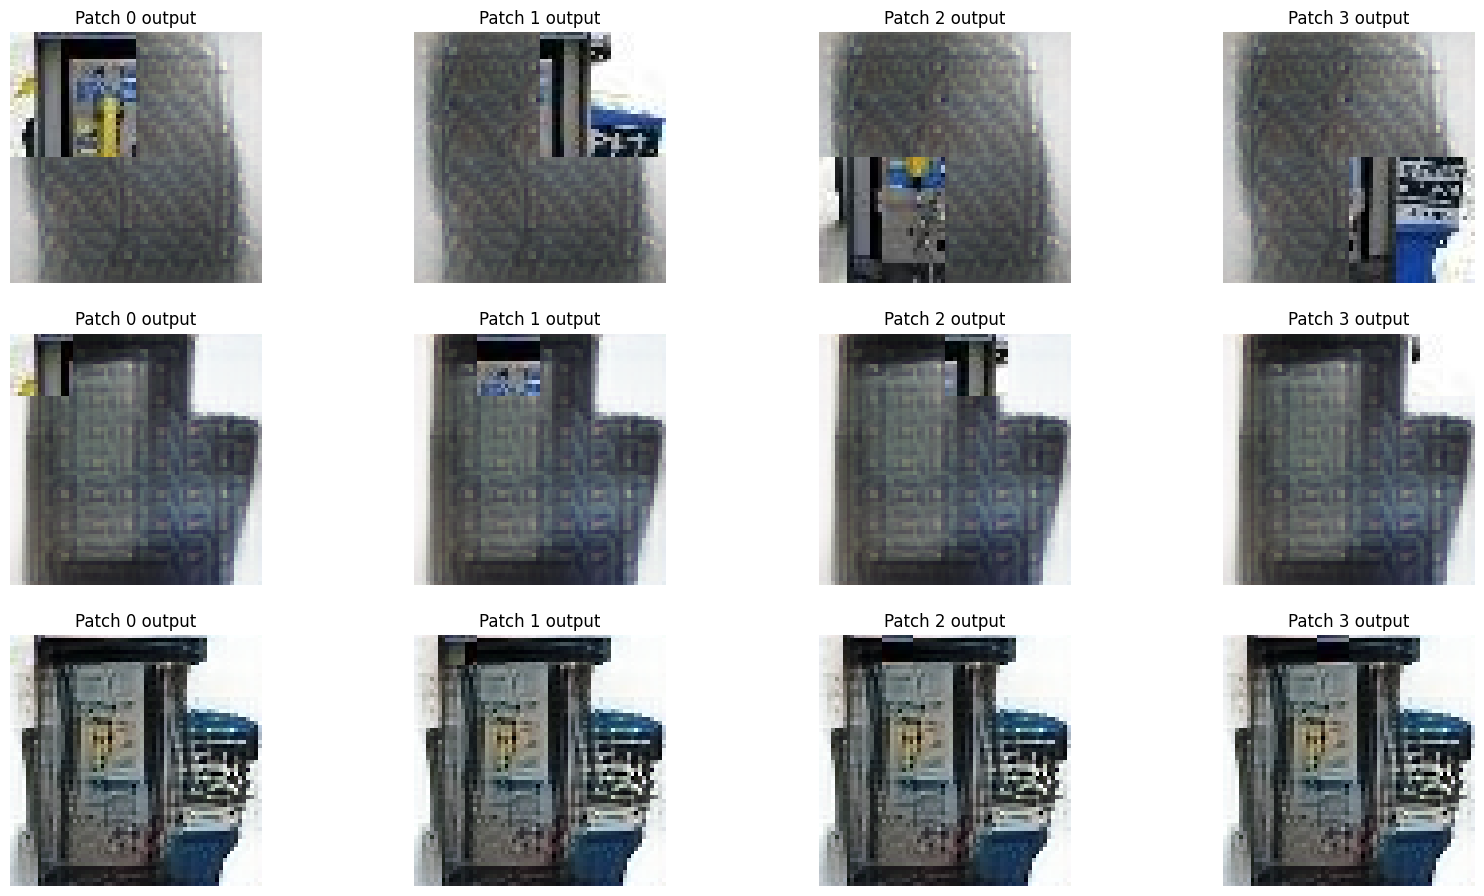

In [9]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    _, _, _, _, diff, info = model.encode(x.to("mps"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    quant1 = model.quantize_1.get_codebook_entry(info1, (5, 16, 16, 8))
    quant2 = model.quantize_2.get_codebook_entry(info2, (5, 8, 8, 8))
    quant3 = model.quantize_3.get_codebook_entry(info3, (5, 4, 4, 8))
    quant4 = model.quantize_4.get_codebook_entry(info4, (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

# Set up subplot grid
plt.figure(figsize=(20,15))
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0)], dim=0)
zeros = [zero1, zero2, zero3, zero4]

loss = VQLPIPSWithDiscriminatorInference().to("mps")

patch_difficulties = [torch.zeros(5,2,2), torch.zeros(5,4,4), torch.zeros(5,8,8)]

# fourth level 2x2
patches = 0
x = x.to("mps")
base_losses = loss(x, images[0])
for i in range(2):
    for j in range(2):
        detail = images[0].clone()
        detail[:, :, 32*i:32*(i+1), 32*j:32*(j+1)] = x[:, :, 32*i:32*(i+1), 32*j:32*(j+1)]
            
        detail_losses = loss(x, detail)
        patch_losses = base_losses - detail_losses
        patch_difficulties[0][:,i,j] = patch_losses
        
        if patches < 4:
            plt.subplot(4, 4, 1 + patches)
            plt.imshow((detail[3].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
            plt.title(f"Patch {patches} output")
            plt.axis('off')
        
        patches += 1
        
print(patch_difficulties[0][3,:,:])

# third level 4x4
patches = 0
base_losses = loss(x, images[1])
for i in range(4):
    for j in range(4):
        detail = images[1].clone()
        detail[:, :, 16*i:16*(i+1), 16*j:16*(j+1)] = x[:, :, 16*i:16*(i+1), 16*j:16*(j+1)]
            
        detail_losses = loss(x, detail)
        patch_losses = base_losses - detail_losses
        patch_difficulties[1][:,i,j] = patch_losses
        
        if patches < 4:
            plt.subplot(4, 4, 5 + patches)
            plt.imshow((detail[3].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
            plt.title(f"Patch {patches} output")
            plt.axis('off')
        
        patches += 1
        
print(patch_difficulties[1][3,:,:])
# second level 8x8
patches = 0
base_losses = loss(x, images[2])
for i in range(8):
    for j in range(8):
        detail = images[2].clone()
        detail[:, :, 8*i:8*(i+1), 8*j:8*(j+1)] = x[:, :, 8*i:8*(i+1), 8*j:8*(j+1)]
            
        detail_losses = loss(x, detail)
        patch_losses = base_losses - detail_losses
        patch_difficulties[2][:,i,j] = patch_losses
        
        if patches < 4:
            plt.subplot(4, 4, 9 + patches)
            plt.imshow((detail[3].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
            plt.title(f"Patch {patches} output")
            plt.axis('off')
        
        patches += 1

print(patch_difficulties[2][3,:,:])
